<a href="https://colab.research.google.com/github/Muvidha/webpro/blob/main/Kelompok_2_UAS_Analisis_Big_Data_Source_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*perintah `!pip install torchsummary --quiet` digunakan dalam lingkungan Python untuk menginstal pustaka bernama `torchsummary` secara diam-diam (tanpa menampilkan output instalasi yang detail).*

In [ ]:
!pip install torchsummary --quiet

# **Importing the required libraries**

*mengimpor modul atau pustaka Python yang diperlukan untuk melaksanakan beberapa fungsi atau tugas tertentu dalam proyek atau skrip*

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt

# **Loading the data from dataset**

*Kode `from google.colab import drive` dan `drive.mount('/content/drive')` digunakan dalam lingkungan Google Colab untuk mengaitkan dan mengakses Google Drive dari dalam notebook Colab.*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Mendefinisikan beberapa variabel yang berisi jalur direktori untuk data pelatihan (`train_dir`), data pengujian (`test_dir`), dan data validasi (`valid_dir`). Selanjutnya, kode ini mencetak isi dari setiap direktori tersebut dan mendefinisikan variabel `CLASS_NAMES` berdasarkan isi direktori pelatihan.*


---


*Isi dari direktori-data yang digunakan dalam proyek, yaitu menampilkan output dari kelas Crazing', 'Pitted', 'Inclusion', 'Patches', 'Scratches', 'Rolled'*

In [ ]:
train_dir = "/content/drive/MyDrive/NEU Metal Surface Defects Data/train"
test_dir = "/content/drive/MyDrive/NEU Metal Surface Defects Data/test"
valid_dir = "/content/drive/MyDrive/NEU Metal Surface Defects Data/valid"

print("Path Directory: ", os.listdir("/content/drive/MyDrive/NEU Metal Surface Defects Data"))
print("Train Directory:",os.listdir(train_dir))
print("valid Direcory: ", os.listdir(valid_dir))
print("Test Directory: ", os.listdir(test_dir))

CLASS_NAMES = sorted(os.listdir(train_dir))

Path Directory:  ['Thumbs.db', 'train', 'test', 'valid']
Train Directory: ['Crazing', 'Pitted', 'Inclusion', 'Patches', 'Scratches', 'Rolled']
valid Direcory:  ['Crazing', 'Rolled', 'Scratches', 'Patches', 'Inclusion', 'Pitted']
Test Directory:  ['Inclusion', 'Rolled', 'Pitted', 'Patches', 'Scratches', 'Crazing']


# **Image Processing**

*mendefinisikan beberapa parameter penting dalam sebuah program, kemungkinan besar terkait dengan pembelajaran mesin atau pemrosesan gambar.*

In [ ]:
# Define some parameters
batch_size = 32
image_size = (224, 224)

*menyiapkan data gambar untuk pelatihan model pembelajaran mesin menggunakan peningkatan data untuk kumpulan pelatihan dan menerapkan pra-pemrosesan yang sesuai untuk kumpulan validasi dan pengujian.*

In [ ]:
# Data augmentation for the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No data augmentation for validation and test data, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow validation images in batches using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow test images in batches using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Important for correct order in confusion matrix
)


Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


*Direktori penyimpanan  VGG16*

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 2s 0us/step


*dilakukan pembekuan (freeze) lapisan-lapisan dari model dasar (base model) yang menggunakan arsitektur VGG16. Pembekuan ini berarti bahwa bobot (weights) dari lapisan-lapisan tersebut tidak akan diperbarui atau dilatih kembali selama proses pelatihan model. Hal ini umumnya dilakukan ketika kita menggunakan model yang telah dilatih sebelumnya dan ingin menambahkan lapisan-lapisan kustom di atasnya tanpa mempengaruhi pembelajaran pada lapisan-lapisan dasar.*

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of VGG16 base
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# **Building and Training Model**

*Pemanggilan model.summary() adalah fungsi yang digunakan untuk mencetak ringkasan model Keras.*

---
*Pemanggilan ini dapat digunakan untuk mendapatkan gambaran umum tentang struktur dan ukuran model. Informasi ini dapat berguna untuk memahami kinerja model dan untuk memperkirakan waktu pelatihan dan kebutuhan memori.*




In [ ]:
# Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

*Dengan melakukan kompilasi menggunakan konfigurasi ini, model siap untuk dipelajari (trained) menggunakan data pelatihan dengan menggunakan optimizer Adam, fungsi kerugian categorical crossentropy, dan mengukur akurasi sebagai metrik evaluasi*

In [ ]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

*Pada saat melatih model, proses ini akan mengoptimalkan bobot dan bias model berdasarkan fungsi kerugian (loss function) yang telah ditentukan sebelumnya (dalam kasus ini, categorical crossentropy). Hasil pelatihan, seperti akurasi dan loss, akan disimpan dalam objek history untuk analisis lebih lanjut atau visualisasi.*

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
)


Epoch 1/20
51/51 [==============================] - 707s 14s/step - loss: 1.4323 - accuracy: 0.6564 - val_loss: 0.1600 - val_accuracy: 0.9688
Epoch 2/20
51/51 [==============================] - 29s 575ms/step - loss: 0.3789 - accuracy: 0.8633 - val_loss: 0.0437 - val_accuracy: 1.0000
Epoch 3/20
51/51 [==============================] - 30s 578ms/step - loss: 0.3037 - accuracy: 0.8935 - val_loss: 0.0566 - val_accuracy: 0.9844
Epoch 4/20
51/51 [==============================] - 30s 586ms/step - loss: 0.3023 - accuracy: 0.8972 - val_loss: 0.0603 - val_accuracy: 0.9844
Epoch 5/20
51/51 [==============================] - 30s 580ms/step - loss: 0.2344 - accuracy: 0.9187 - val_loss: 0.0485 - val_accuracy: 0.9844
Epoch 6/20
51/51 [==============================] - 32s 619ms/step - loss: 0.2339 - accuracy: 0.9206 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 7/20
51/51 [==============================] - 30s 574ms/step - loss: 0.2022 - accuracy: 0.9317 - val_loss: 0.0291 - val_accuracy: 1.0000


*Hasil pelatihan dan validasi akan disimpan dalam objek `history`, yang dapat gunakan nantinya untuk menganalisis dan memvisualisasikan kinerja model. Dengan demikian, setelah 20 epoch, model akan memiliki parameter yang disesuaikan dengan data pelatihan dan dapat digunakan untuk melakukan prediksi pada data baru. Hasil outpunya akan menampilkan loss, akurasi, validasi akurasi, dan loss akurasi yang dimana menjadi tolak ukur dalam penggunaan model yang akan digunakan.*

# **Test the model on test dataset**

*Menguji model pada dataset uji (test set) dan mengevaluasi kinerjanya. Menggunakan metode `evaluate` pada model untuk mengevaluasi performanya pada dataset uji*

---
*Fungsi `evaluate` akan mengembalikan dua nilai: nilai kerugian (loss) pada dataset uji dan akurasi pada dataset uji.*

---
*Akurasi pengujian adalah persentase data uji yang diklasifikasikan dengan benar oleh model. Dengan mencetak nilai akurasi, dapat melihat seberapa baik model dapat menggeneralisasi pada data baru yang belum pernah dilihat sebelumnya. Sehingga, output yang ditampilkan yaitu akurasi 1. Akurasi tersebut dapat dikategorikan tinggi sehingga model dikatakan baik.*


In [ ]:
# Test the model
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)

3/3 [==============================] - 22s 11s/step - loss: 0.0311 - accuracy: 1.0000
Test Loss:  0.031106531620025635
Test Accuracy:  1.0


# **Plot Confunsion Matrix**

*Membuat dan memvisualisasikan confusion matrix, yang merupakan alat evaluasi kinerja model klasifikasi.*

---
*Dengan memahami confusion matrix, dapat melihat dengan lebih rinci seberapa baik melakukan klasifikasi untuk setiap kelas pada dataset uji*.



3/3 [==============================] - 1s 196ms/step


<ipython-input-14-0466beba25f1>:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), fraction=0.046, pad=0.04)


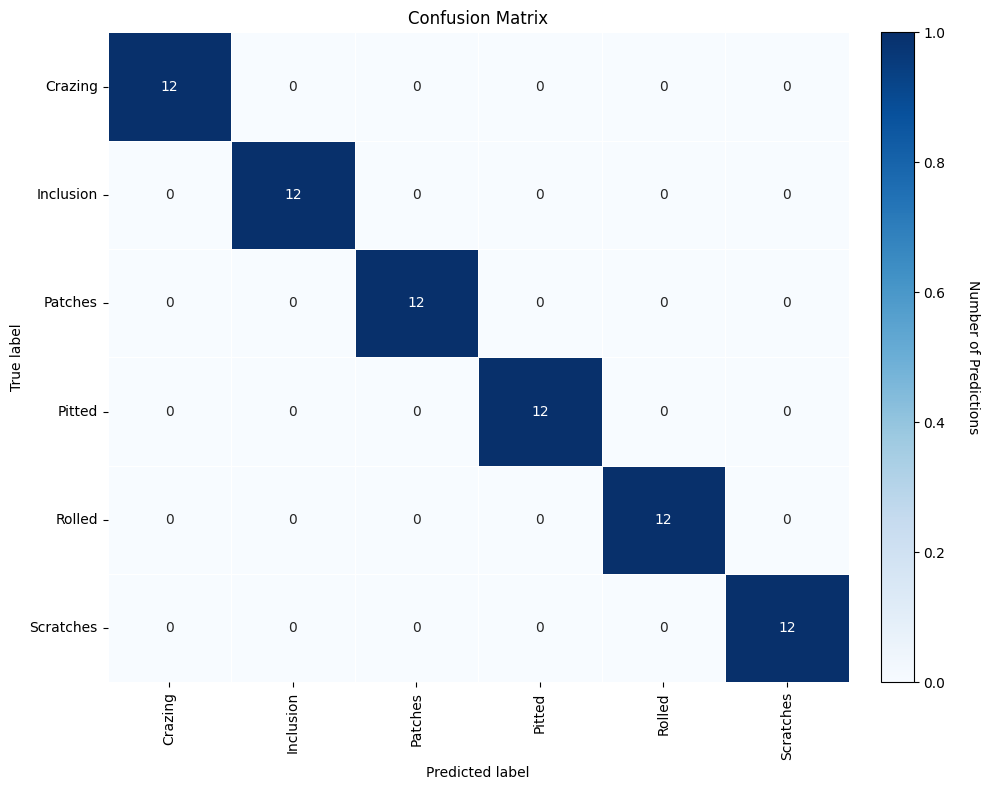

Classification Report
              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        12
   Inclusion       1.00      1.00      1.00        12
     Patches       1.00      1.00      1.00        12
      Pitted       1.00      1.00      1.00        12
      Rolled       1.00      1.00      1.00        12
   Scratches       1.00      1.00      1.00        12

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



In [ ]:
# Predict the values from the test dataset
Y_pred = model.predict(test_generator, test_generator.samples // batch_size + 1)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = test_generator.classes

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False, linewidths=.5)
plt.title('Confusion Matrix')
tick_marks = np.arange(len(CLASS_NAMES))
plt.xticks(tick_marks + 0.5, CLASS_NAMES, rotation=90)
plt.yticks(tick_marks + 0.5, CLASS_NAMES, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Add a side color bar to show the scale
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), fraction=0.046, pad=0.04)
cbar.set_label('Number of Predictions', rotation=270, labelpad=25)

# Tight layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

# Print the classification report
print('Classification Report')
print(classification_report(Y_true, Y_pred_classes, target_names=CLASS_NAMES))

# **KESIMPULAN**

*Kesimpulan yang diperoleh yaitu Implementasi dari model VVG16memiliki performa yang baik dalam mengklasifikasi jenis cacat pada permukaan logam neu. Penelitian ini didapatkan nilai accuracy 100% hasil itu membuktikan bahwa model VVG16 memiliki kinerja yang baik dalam mengklasifikasi gambar cacat dari permukaan logam neu.*